In [110]:
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

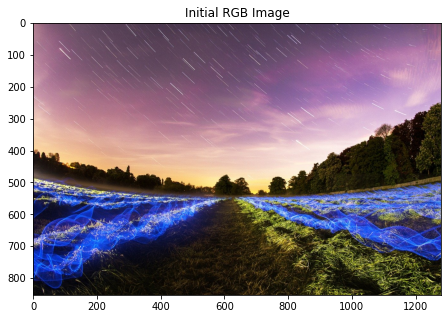

In [272]:
# Load image
img_directory = "photo1.png"
img_rgb = Image.open(img_directory).convert('RGB')      # Convert to RGB (remove alpha dimention)
img_rgb_matrix = np.array(img_rgb)                      # Convert to RGB matrix

# Show image
plt.figure(figsize = (10, 5))
plt.imshow(img_rgb_matrix)
plt.title('Initial RGB Image')
plt.show()

## Phase 1) Convert RGB to YCbCr and Chroma Subsampling

### Convert RGB to YCbCr

In [273]:
def rgb_to_ycbcr(im):
    ''' Convert RGB image to YCbCr '''

    # Coefficients
    coefs = [[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]]

    # Convert to YCbCr
    ycbcr = im.dot(np.array(coefs).T)

    # Shift 128 pixels to the center of the range
    ycbcr[:,:,[1,2]] += 128

    # Return as unsigned 8-bit integers
    return np.uint8(ycbcr)


def ycbcr_to_rgb(im):
    ''' Convert YCbCr image to RGB '''

    # Coefficients
    coefs = [[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]]

    xform = np.array(coefs)
    rgb = im.astype(np.float)

    # Shift back to the range [0, 255]
    rgb[:,:,[1,2]] -= 128

    # Convert to RGB
    rgb = rgb.dot(xform.T)

    # Clip to [0, 255]
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)

    # Return as unsigned 8-bit integers
    return np.uint8(rgb)

In [287]:
# img_ycbcr = img_rgb.convert('YCbCr')

# # Show image
# plt.figure(figsize = (10, 5))
# plt.imshow(img_ycbcr)
# plt.title('Initial RGB Image')
# plt.show()

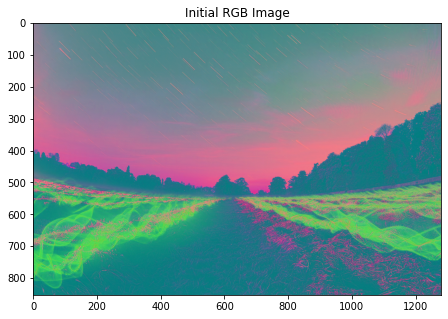

In [286]:
img_ycbcr = rgb_to_ycbcr(img_rgb_matrix)

# Show image
plt.figure(figsize = (10, 5))
plt.imshow(img_ycbcr)
plt.title('Initial RGB Image')
plt.show()

### Chroma Subsampling

In [278]:
# Make image dimensions multiple of 8

img_ycbcr_matrix = np.array(img_ycbcr)
print('Original image dimensions: ', img_ycbcr_matrix.shape)

# Create and reshape the row
row = np.zeros((1280, 3)).reshape((1, 1280, 3))

img_ycbcr_matrix = np.vstack((img_ycbcr_matrix, row, row, row))
print('Reshaped image dimensions: ', img_ycbcr_matrix.shape)

Original image dimensions:  (853, 1280, 3)
Reshaped image dimensions:  (856, 1280, 3)


In [279]:
# For Cb and Cr
for i in [1, 2]:
    # Get the Chroma dimension
    temp = img_ycbcr_matrix[:, :, i].copy()

    # Vertically, every second element equals to element above itself.
    temp[1::2, :] = temp[::2, :]

    # Horizontally, every second element equals to the element on its left side.
    temp[:, 1::2] = temp[:, ::2]

    # Replace the subsampled dimension with the new one
    img_ycbcr_matrix[:, :, i] = temp

## Phase 2) Convert to Blocks and Apply DCT

### Convert tot blocks

In [347]:
blocks_size = 8

# Three dimentions, three lists of blocks
blocks = [[], [], []]

for i in range(img_ycbcr_matrix.shape[2]):
    for r in range(0, img_ycbcr_matrix.shape[0] - blocks_size + 1, blocks_size):
        for c in range(0, img_ycbcr_matrix.shape[1] - blocks_size + 1, blocks_size):
            blocks[i].append(img_ycbcr_matrix[r:r + blocks_size, c:c + blocks_size, i])

print('Rows: ', img_ycbcr_matrix.shape[0])
print('Columns: ', img_ycbcr_matrix.shape[1])
print('Blocks for Rows:', img_ycbcr_matrix.shape[0] // 8)
print('Blocks for Columns:', img_ycbcr_matrix.shape[1] // 8)
print('Total Blocks:', len(blocks[0]))

Rows:  856
Columns:  1280
Blocks for Rows: 107
Blocks for Columns: 160
Total Blocks: 17120


### Apply DCT

In [320]:
dcts = [[], [], []]
for i in range(3):
    for block in blocks[i]:
        dcts[i].append(cv2.dct(block))

print(dcts[0][0].shape)

(8, 8)


### Quantization

In [321]:
QY = np.array([
    [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,48,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103,99]]
)

QC = np.array([
    [17,18,24,47,99,99,99,99],
    [18,21,26,66,99,99,99,99],
    [24,26,56,99,99,99,99,99],
    [47,66,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99]]
)

# 1 for Luminance, 2 for Chromas
Q = [QY, QC, QC]

In [341]:
quantized_dcts = dcts.copy()
for i in range(3):
    for j in range(len(dcts)):
        quantized_dcts[i][j] = np.array(dcts[i][j]) // Q[i]

## Phase 4) Huffman Coding

In [298]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm

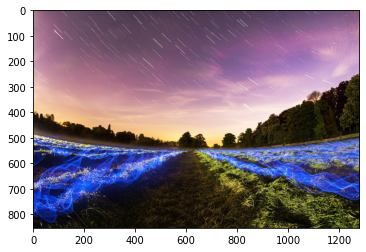

In [299]:
B=8 # blocksize (In Jpeg the
img1 = cv2.imread("photo1.png", cv2.IMREAD_COLOR)
h,w=np.array(img1.shape[:2])/B * B
h, w = int(h), int(w)
img1=img1[:h,:w]
#Convert BGR to RGB
img2=np.zeros(img1.shape,np.uint8)
img2[:,:,0]=img1[:,:,2]
img2[:,:,1]=img1[:,:,1]
img2[:,:,2]=img1[:,:,0]
plt.imshow(img2)

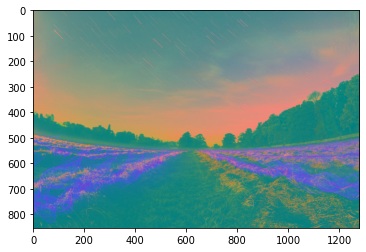

In [300]:
transcol=cv2.cvtColor(img1, cv2.COLOR_BGR2YCR_CB)
plt.imshow(transcol)
plt.show()

In [305]:
SSV=2
SSH=2
crf=cv2.boxFilter(transcol[:,:,1],ddepth=-1,ksize=(2,2))
cbf=cv2.boxFilter(transcol[:,:,2],ddepth=-1,ksize=(2,2))
crsub=crf[::SSV,::SSH]
cbsub=cbf[::SSV,::SSH]
imSub=[transcol[:,:,0],crsub,cbsub]

In [312]:
QF=99.0
if QF < 50 and QF > 1:
        scale = np.floor(5000/QF)
elif QF < 100:
        scale = 200-2*QF
else:
        print("Quality Factor must be in the range [1..99]")
scale=scale/100.0
Q=[QY*scale,QC*scale,QC*scale]

print(Q[0].shape)

(8, 8)


NameError: name 'srow' is not defined

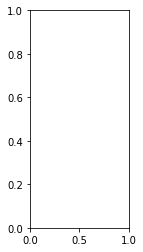

In [314]:
TransAll=[]
TransAllQuant=[]
ch=['Y','Cr','Cb']
plt.figure()
for idx,channel in enumerate(imSub):
        plt.subplot(1,3,idx+1)
        channelrows=channel.shape[0]
        channelcols=channel.shape[1]
        Trans = np.zeros((channelrows,channelcols), np.float32)
        TransQuant = np.zeros((channelrows,channelcols), np.float32)
        blocksV=channelrows//B
        blocksH=channelcols//B
        vis0 = np.zeros((channelrows,channelcols), np.float32)
        vis0[:channelrows, :channelcols] = channel
        vis0=vis0-128
        for row in range(blocksV):
                for col in range(blocksH):
                        currentblock = cv2.dct(vis0[row*B:(row+1)*B,col*B:(col+1)*B])
                        Trans[row*B:(row+1)*B,col*B:(col+1)*B]=currentblock
                        TransQuant[row*B:(row+1)*B,col*B:(col+1)*B]=np.round(currentblock/Q[idx])
        TransAll.append(Trans)
        TransAllQuant.append(TransQuant)
        if idx==0:
                selectedTrans=Trans[srow*B:(srow+1)*B,scol*B:(scol+1)*B]
        else:
                sr=np.floor(srow/SSV)
                sc=np.floor(scol/SSV)
                selectedTrans=Trans[sr*B:(sr+1)*B,sc*B:(sc+1)*B]
        plt.imshow(selectedTrans,cmap=cm.jet,interpolation='nearest')
        plt.colorbar(shrink=0.5)
        plt.title('DCT of '+ch[idx])